In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import fastcore.all as fc
from fastai.vision.all import show_image, show_images
from datasets import load_dataset

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader

from tinyai.core import inplace, def_device, to_device
from tinyai.training import fit, cross_entropy, collate_ds
from tinyai.conv import conv

In [ ]:
dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o).flatten() for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
})

In [ ]:
from torch.utils.data import default_collate

class DataLoaders:
    def __init__(self, train_ds, valid_ds): self.train, self.valid = train_ds, valid_ds

    @classmethod
    def from_dd(cls, dd, batch_size, num_workers=1):
        return cls(*[DataLoader(ds, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_ds(ds)) for ds in dd.values()])

In [ ]:
# dls = DataLoaders.from_dd_one_batch_train(tds, bs, num_workers=1) # to overfit
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [ ]:
xb, yb = next(iter(dls.train))
xb.device

device(type='cpu')

In [ ]:
class Metric:
    def __init__(self): self.reset()

    def add(self, inps, targs=None, n=1):
        self.last = self.calc(inps, targs)
        self.vals.append(self.last)
        self.ns.append(n)
        
    def reset(self): self.vals, self.ns = [], []

    def calc(self, inps, targs): return inps

    @property
    def value(self):
        ns = torch.tensor(self.ns)
        return (torch.tensor(self.vals) * ns).sum() / ns.sum()

class Accuracy(Metric):
    def __init__(self, argmax=False): 
        super().__init__()
        self.argmax = argmax
    def calc(self, inps, targs): 
        if self.argmax: inps = inps.argmax(dim=1)
        return (inps == targs).float().mean()

In [ ]:
loss = Metric()
acc = Accuracy()

In [ ]:
xb, yb = torch.tensor([1,3,4,6,3,4,1,0,0,0]),  torch.tensor([1,3,4,6,3,4,1,0,0,1]) # 90%
acc.add(xb, yb, xb.shape[0])

In [ ]:
acc.value

tensor(0.9000)

In [ ]:
loss.add(0.6, n=32)
loss.add(0.9, n=2)

loss.value, (0.6*32+0.9*2)/(32+2)

(tensor(0.6176), 0.6176470588235294)

## Original Learner

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()
        self.model = model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)

    @torch.no_grad()
    def calc_stats(self, xb, yb, preds, loss):
        n = len(xb)
        self.acc.append((preds.argmax(dim=1) == yb).float().sum()) # divide by n
        self.losses.append(loss*n)
        self.ns.append(n)

    def one_batch(self, i, b):
        xb,yb = to_device(b)
        preds = self.model(xb)
        loss = self.loss_func(preds, yb)
        
        if self.model.training:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            
        self.calc_stats(xb, yb, preds, loss)

    def log(self, train:bool, epoch):
        n = sum(self.ns)
        acc = sum(self.acc)/n
        loss = sum(self.losses)/n
        print(f"{'Train' if train else 'Valid'} {epoch} loss: {loss:.4f}, accuracy: {acc:.4f}")
        
    def one_epoch(self, epoch, train: bool):
        if train:
            model.train()
            dl = self.dls.train
        else:
            model.eval()
            dl = self.dls.valid

        self.acc, self.losses, self.ns = [], [], []
        for i, b in enumerate(dl): self.one_batch(i, b)
        self.log(train, epoch)

    def fit(self, n_epochs):
        for epoch in range(n_epochs):
            self.one_epoch(epoch, train=True)
            self.one_epoch(epoch, train=False)

In [ ]:
def get_model():
    return nn.Sequential(
        nn.Linear(28*28, 50), nn.ReLU(), nn.Linear(50, 10)
    )

In [ ]:
model = get_model()
learn = Learner(model, dls, cross_entropy, 0.5, optim.SGD)

In [ ]:
learn.fit(3)

/Users/tom/fun/tinyai/tinyai/training.py:37: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


Train 0 loss: 1.1980, accuracy: 0.5548
Valid 0 loss: 0.8142, accuracy: 0.6734
Train 1 loss: 0.6618, accuracy: 0.7513
Valid 1 loss: 0.6399, accuracy: 0.7470
Train 2 loss: 0.5823, accuracy: 0.7822
Valid 2 loss: 0.6725, accuracy: 0.7525


## A more generic Learner

In [ ]:
from operator import attrgetter
from functools import partial
import fastcore.all as fc

import torch
from torch import optim

class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass
    
class Callback(): order = 0
class TrainCB(Callback): 
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn):
        learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

class ToDeviceCB(Callback):
    def before_fit(self, learn): learn.model = learn.model.to(def_device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch)


class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _inner(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _inner

def run_cbs(cbs, method_nm, learn=None, ignored=None):
    ignored = fc.L(ignored)
    for cb in sorted(cbs, key=attrgetter('order')):
        if type(cb).__name__ in ignored: continue
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)
                
class Learner:
    def __init__(self, model, dls, loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        fc.store_attr()
        self.model = model.to(def_device)
        self.cbs = fc.L(cbs)

    def fit(self, n_epochs, train=True, valid=True, cbs=None, lr=None, ignore_cbs=None):
        self.ignore_cbs = fc.L(ignore_cbs)
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            self.opt = self.opt_func(self.model.parameters(), lr=lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(training=True)
            if valid: torch.no_grad()(self.one_epoch)(training=False)

    def one_epoch(self, training: bool):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @property
    def training(self): return self.model.training

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter, self.batch in enumerate(self.dl): self._one_batch()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, learn=self, ignored=self.ignore_cbs)
        
    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def lr_find(self, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
        self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma, max_mult))

In [ ]:
import pandas as pd

from copy import copy
from torcheval.metrics import MulticlassAccuracy, Mean
from tinyai.core import to_cpu

class MetricsCB(Callback):
    show_train = False
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.loss = Mean()

    def _log(self, log):
        print(log)
            
    def before_fit(self, learn): 
        learn.metrics = self

    def before_epoch(self, learn):
        self.loss.reset()
        for o in self.metrics.values():
            o.reset()

    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)

    def after_epoch(self, learn):
        if self.show_train or not learn.training:
            log = dict(Epoch=learn.epoch, Train='train' if learn.model.training else 'eval', Loss=f"{self.loss.compute().item():.4f}",)
            log.update({k: f"{v.compute().item():.4f}" for k,v in self.metrics.items()})
            self._log(log)

In [ ]:
class EarlyStoppingCB(MetricsCB):
    order = ProgressCB.order + 1
    def __init__(self, patience=1, metric=None):
        "metric = None uses Validation Loss"
        if metric is None:
            super().__init__()
            self.metric = self.loss
        else:
            super().__init__(es_metric=metric)
            self.metric = self.metrics["es_metric"]
        
        self.init_patience = patience
        self.patience = patience
        self.best_metric = float('inf')
        
    def after_epoch(self, learn):
        if not learn.training:
            metric = self.metric.compute().item()
            if metric > self.best_metric:
                self.patience -= 1
                if self.patience == 0:
                    # print(f"Early stopping on epoch {learn.epoch}: new loss {metric:.4f}, previous best {self.best_metric:.4f}")
                    raise CancelFitException()
            else:
                self.patience = self.init_patience
                self.best_metric = metric


In [ ]:
from fastprogress import progress_bar,master_bar
import sys

class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        sys.stdout.flush()

    def cleanup_fit(self, learn):
        learn.metrics.after_epoch(learn)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.loss.compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])


In [ ]:
model = get_model()
learn = Learner(model, dls, cross_entropy, 1.5, cbs=[ToDeviceCB(), TrainCB(), MetricsCB(MulticlassAccuracy()), ProgressCB(plot=False), EarlyStoppingCB(patience=3)], opt_func=optim.SGD)
learn.fit(20)

Epoch,Train,Loss,MulticlassAccuracy
0,eval,2.3054,0.1013
1,eval,2.3024,0.1014
2,eval,2.3028,0.1014
3,eval,2.3028,0.1014


In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
import math
import matplotlib.pyplot as plt
from overrides import override

class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, gamma=self.gamma)
        self.lrs, self.losses = [], []
        self.min = float('inf')

    def before_epoch(self, learn):
        if not learn.training:
            raise CancelEpochException()

    def after_batch(self, learn):
        loss = to_cpu(learn.loss)
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or loss > self.min * self.max_mult:
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

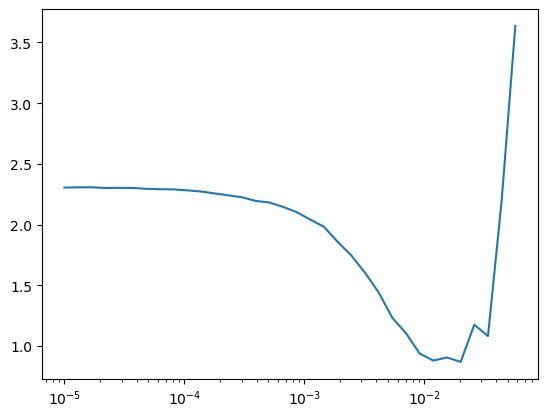

In [ ]:
model = get_model()
learn = Learner(model, dls, cross_entropy, 0.5, cbs=[ToDeviceCB(), TrainCB(), EarlyStoppingCB(patience=3), MetricsCB(MulticlassAccuracy()), ProgressCB(plot=False)], opt_func=optim.AdamW)
learn.lr_find()